# Stage E: Hyperparameter Tuning + Final Evaluation

## 1️⃣ 개요

본 노트북은 **Stage D의 베스트 모델을 선정**하고, **하이퍼파라미터 튜닝**을 통해 성능을 최적화한 후, **Test Set에서 최종 평가**하는 것을 목표로 합니다.

### 핵심 목표
1. **Stage D 결과 분석** → 상위 3개 조합 선정
2. **하이퍼파라미터 최적화** → Optuna를 활용한 효율적 탐색
3. **임계값(Threshold) 조정** → Precision-Recall 균형점 탐색
4. **최종 평가** → Test Set 성능 측정 및 Stage C/D 대비 개선도 분석
5. **모델 배포 준비** → 최종 모델 저장 및 해석 자료 생성

---

## 2️⃣ 실험 설계

| 항목 | 내용 |
|------|------|
| **입력 데이터** | `data/processed/base_master_median.parquet` |
| **피처 세트** | `core_features_top40.json` (Stability Selection) |
| **Stage D 결과** | `results/stageD/holdout_metrics_summary.csv` |
| **후보 모델** | Top-3 조합 (LightGBM, XGBoost, RandomForest 중심) |
| **튜닝 방법** | Optuna (Bayesian Optimization) |
| **검증 전략** | Train 90% / Test 10% Holdout |
| **평가 지표** | AUC-PR (1차) → Recall → F1 → Precision |

---

## 3️⃣ 실험 프로세스
```
Step 1: Stage D 결과 로드 및 Top-3 모델 선정
         ↓
Step 2: Optuna로 하이퍼파라미터 튜닝 (각 모델별)
         ↓
Step 3: 최적 파라미터로 최종 학습
         ↓
Step 4: Threshold 최적화 (PR Curve 기반)
         ↓
Step 5: Test Set 최종 평가
         ↓
Step 6: Stage C/D 대비 개선도 분석
         ↓
Step 7: 모델 저장 + 시각화 (Feature Importance, PR/ROC Curve)
```

---

## 4️⃣ 산출물

1. **최종 모델**: `models/final_tuned_model.pkl`
2. **성능 비교표**: `results/stageE/final_performance_comparison.csv`
3. **하이퍼파라미터 로그**: `results/stageE/optuna_study_results.json`
4. **시각화 자료**: 
   - Feature Importance
   - PR Curve / ROC Curve
   - Confusion Matrix
   - Stage별 성능 비교 그래프

---

In [21]:
# ============================================================
# 🧩 Stage E 환경 세팅
# ============================================================

import numpy as np
import pandas as pd
import json, pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ---------------- Optuna ----------------
import optuna
from optuna.samplers import TPESampler

# ---------------- 기본 라이브러리 ----------------
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    recall_score, precision_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve
)

# ---------------- 불균형 처리 ----------------
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

# ---------------- 모델 ----------------
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ---------------- 시각화 ----------------
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 📂 경로 설정
# ============================================================
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

DATA_MASTER = ROOT / 'data' / 'processed' / 'base_master_median.parquet'
CORE_FEATURES_PATH = ROOT / 'results' / 'stageC' / 'core_features_median_top40.json'
STAGE_D_RESULTS = ROOT / 'results' / 'stageD' / 'holdout_metrics_summary.csv'

DIR_RESULTS = ROOT / 'results' / 'stageE'
DIR_MODELS = ROOT / 'models'
DIR_FIGURES = DIR_RESULTS / 'figures'

for d in [DIR_RESULTS, DIR_MODELS, DIR_FIGURES]:
    d.mkdir(parents=True, exist_ok=True)

# ============================================================
# ⚙️ 재현성
# ============================================================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Stage E 환경 세팅 완료")
print(f"  - ROOT: {ROOT}")
print(f"  - 입력 데이터: {DATA_MASTER}")
print(f"  - Stage D 결과: {STAGE_D_RESULTS}")
print(f"  - 출력 디렉토리: {DIR_RESULTS}")
print(f"  - Random State: {RANDOM_STATE}")
print("\n📌 Optuna를 활용한 하이퍼파라미터 튜닝 준비 완료")

✓ Stage E 환경 세팅 완료
  - ROOT: /Users/mealkuo/Desktop/capstone02_project
  - 입력 데이터: /Users/mealkuo/Desktop/capstone02_project/data/processed/base_master_median.parquet
  - Stage D 결과: /Users/mealkuo/Desktop/capstone02_project/results/stageD/holdout_metrics_summary.csv
  - 출력 디렉토리: /Users/mealkuo/Desktop/capstone02_project/results/stageE
  - Random State: 42

📌 Optuna를 활용한 하이퍼파라미터 튜닝 준비 완료


---

## Step 1: Stage D 결과 분석 및 Top-3 모델 선정

### 목적
- Stage D에서 수행한 12개 조합(3 Sampling × 4 Models) 중 상위 3개 선정
- 선정 기준: **AUC-PR 상위 3개**

### 분석 내용
1. Stage D 결과 로드
2. AUC-PR 기준 정렬
3. Top-3 조합 확인
4. 각 조합의 성능 지표 출력

In [22]:
# ============================================================
# Step 1: Stage D 결과 로드 및 Top-3 모델 선정
# ============================================================

print("="*70)
print("Step 1: Stage D 결과 분석 및 Top-3 모델 선정")
print("="*70)

# 1️⃣ Stage D 결과 로드
stage_d_results = pd.read_csv(STAGE_D_RESULTS)
print(f"\n✓ Stage D 결과 로드 완료")
print(f"  - 총 조합 수: {len(stage_d_results)}")

# 2️⃣ AUC-PR 기준 정렬 (이미 정렬되어 있지만 확인)
stage_d_results_sorted = stage_d_results.sort_values('AUC_PR', ascending=False).reset_index(drop=True)

# 3️⃣ Top-3 선정
top3_combinations = stage_d_results_sorted.head(3)

print(f"\n🏆 Top-3 조합 (AUC-PR 기준):")
print("="*70)
for idx, row in top3_combinations.iterrows():
    print(f"\n  [{idx+1}위] {row['Sampling']} + {row['Model']}")
    print(f"      - AUC-PR:  {row['AUC_PR']:.4f}")
    print(f"      - Recall:  {row['Recall']:.4f}")
    print(f"      - F1:      {row['F1']:.4f}")
    print(f"      - ROC-AUC: {row['ROC_AUC']:.4f}")

# 4️⃣ 튜닝 대상 저장
tuning_targets = []
for idx, row in top3_combinations.iterrows():
    tuning_targets.append({
        'rank': idx + 1,
        'sampling': row['Sampling'],
        'model': row['Model'],
        'baseline_auc_pr': row['AUC_PR'],
        'baseline_recall': row['Recall'],
        'baseline_f1': row['F1']
    })

print("\n" + "="*70)
print(f"✅ Top-3 조합 선정 완료 → 하이퍼파라미터 튜닝 대상")
print("="*70)

Step 1: Stage D 결과 분석 및 Top-3 모델 선정

✓ Stage D 결과 로드 완료
  - 총 조합 수: 12

🏆 Top-3 조합 (AUC-PR 기준):

  [1위] SMOTE + LightGBM
      - AUC-PR:  0.3023
      - Recall:  0.2381
      - F1:      0.3030
      - ROC-AUC: 0.7008

  [2위] SMOTE + RandomForest
      - AUC-PR:  0.2555
      - Recall:  0.2381
      - F1:      0.2941
      - ROC-AUC: 0.7754

  [3위] SMOTE+Tomek + CatBoost
      - AUC-PR:  0.2516
      - Recall:  0.2381
      - F1:      0.2703
      - ROC-AUC: 0.6907

✅ Top-3 조합 선정 완료 → 하이퍼파라미터 튜닝 대상


---

## Step 2: 데이터 준비 및 Train/Test Split

### 작업 내용
1. 마스터셋 및 Core Features 로드
2. Train/Test Split (80:20) - Stage D와 동일
3. 데이터 품질 체크

In [23]:
# ============================================================
# Step 2: 데이터 준비 (Train/Test 90:10 Split)
# ============================================================

print("\n" + "="*70)
print("Step 2: 데이터 준비 (Train/Test 80:20 Split)")
print("="*70)

# 1️⃣ 마스터셋 로드
df = pd.read_parquet(DATA_MASTER)
print(f"\n✓ 마스터셋 로드: {df.shape}")

# 2️⃣ Core Features 로드
with open(CORE_FEATURES_PATH, 'r') as f:
    core_features_info = json.load(f)
core_features = core_features_info['features']
print(f"✓ Core Features 로드: {len(core_features)}개")

# 3️⃣ 전체 X/y 구성
X = df[core_features].copy()
y = df['label'].copy()

# 4️⃣ Train/Test Split (80:20)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20%을 Test로
    random_state=RANDOM_STATE,
    stratify=y
    )

# 5️⃣ (옵션) Tuning/Validation용으로 Train에서 작은 Val 분리(전체의 10%)
#     → Val은 튜닝/threshold 탐색에 사용하고, 최종 모델은 Train_full(90%)로 재학습합니다.
val_frac_of_train = 0.2 / 0.8  # Train_full에서 분리할 비율 (≈0.111111)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=val_frac_of_train,
    random_state=RANDOM_STATE,
    stratify=y_train_full
)

print(f"\n✓ Split 완료 (Train_full 90% / Test 10%)")
print(f"  - Train_full: {X_train_full.shape[0]} samples ({X_train_full.shape[0]/len(X)*100:.1f}%)")
print(f"  - Train (for tuning): {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
#print(f"  - Val (for tuning):   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  - Test:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\n  [클래스 분포]")
print(f"  - Train_full: {y_train_full.value_counts().to_dict()}")
print(f"  - Train (for tuning): {y_train.value_counts().to_dict()}")
#print(f"  - Val:   {y_val.value_counts().to_dict()}")
print(f"  - Test:  {y_test.value_counts().to_dict()}")

print("\n⚠️  중요: Test Set은 최종 평가 전까지 절대 사용하지 않음!")
print("="*70)


Step 2: 데이터 준비 (Train/Test 80:20 Split)

✓ 마스터셋 로드: (1567, 252)
✓ Core Features 로드: 39개

✓ Split 완료 (Train_full 90% / Test 10%)
  - Train_full: 1253 samples (80.0%)
  - Train (for tuning): 939 samples (59.9%)
  - Test:  314 samples (20.0%)

  [클래스 분포]
  - Train_full: {0: 1170, 1: 83}
  - Train (for tuning): {0: 877, 1: 62}
  - Test:  {0: 293, 1: 21}

⚠️  중요: Test Set은 최종 평가 전까지 절대 사용하지 않음!


---

## Step 3: Optuna 기반 하이퍼파라미터 튜닝

### 튜닝 전략
- **방법**: Optuna (Bayesian Optimization with TPE Sampler)
- **목표 지표**: AUC-PR 최대화
- **Trial 수**: 각 모델당 50회
- **Validation**: 5-Fold Stratified CV (Train 내에서만)

### 튜닝 대상 파라미터

| 모델 | 주요 파라미터 |
|------|---------------|
| **LightGBM** | num_leaves, max_depth, learning_rate, n_estimators, feature_fraction, bagging_fraction |
| **XGBoost** | max_depth, learning_rate, n_estimators, subsample, colsample_bytree, gamma |
| **RandomForest** | n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features |

### 프로세스
```
각 Top-3 조합에 대해:
  1. Optuna Study 생성
  2. Objective 함수 정의 (Sampling + Model + CV)
  3. 50회 Trial 실행
  4. Best Parameters 저장
```

In [24]:
# ============================================================
# Step 3: Optuna 하이퍼파라미터 튜닝 함수 정의 (Val 기반)
# ============================================================

# Sampling 객체 딕셔너리
sampling_dict = {
    'SMOTE': SMOTE(random_state=RANDOM_STATE),
    'SMOTE+Tomek': SMOTETomek(random_state=RANDOM_STATE),
    'RUS': RandomUnderSampler(random_state=RANDOM_STATE)
}

# ============================================================
# Objective 함수: LightGBM (Val 기반 평가)
# ============================================================
def objective_lgbm(trial, X_tr, y_tr, X_v, y_v, sampler):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'class_weight': None,
        'random_state': RANDOM_STATE,
        'verbose': -1
    }
    
    # Train에만 샘플링 적용
    X_resampled, y_resampled = sampler.fit_resample(X_tr, y_tr)
    
    # 모델 학습
    model = LGBMClassifier(**params)
    model.fit(X_resampled, y_resampled)
    
    # Val 평가 (원본 분포)
    y_proba = model.predict_proba(X_v)[:, 1]
    auc_pr = average_precision_score(y_v, y_proba)
    
    return auc_pr

# ============================================================
# Objective 함수: XGBoost (Val 기반 평가)
# ============================================================
def objective_xgb(trial, X_tr, y_tr, X_v, y_v, sampler):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': (y_tr == 0).sum() / (y_tr == 1).sum(),
        'random_state': RANDOM_STATE,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
    
    X_resampled, y_resampled = sampler.fit_resample(X_tr, y_tr)
    
    model = XGBClassifier(**params)
    model.fit(X_resampled, y_resampled)
    
    y_proba = model.predict_proba(X_v)[:, 1]
    auc_pr = average_precision_score(y_v, y_proba)
    
    return auc_pr

# ============================================================
# Objective 함수: RandomForest (Val 기반 평가)
# ============================================================
def objective_rf(trial, X_tr, y_tr, X_v, y_v, sampler):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': None,
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
    
    X_resampled, y_resampled = sampler.fit_resample(X_tr, y_tr)
    
    model = RandomForestClassifier(**params)
    model.fit(X_resampled, y_resampled)
    
    y_proba = model.predict_proba(X_v)[:, 1]
    auc_pr = average_precision_score(y_v, y_proba)
    
    return auc_pr

print("✓ Optuna Objective 함수 정의 완료 (Val 기반 평가)")
print("  - Train 60%로 학습, Val 20%로 평가")

✓ Optuna Objective 함수 정의 완료 (Val 기반 평가)
  - Train 60%로 학습, Val 20%로 평가


In [25]:
# ============================================================
# Step 3: Optuna 하이퍼파라미터 튜닝 함수 정의 (Val 기반)
# ============================================================

# Sampling 객체 딕셔너리
sampling_dict = {
    'SMOTE': SMOTE(random_state=RANDOM_STATE),
    'SMOTE+Tomek': SMOTETomek(random_state=RANDOM_STATE),
    'RUS': RandomUnderSampler(random_state=RANDOM_STATE)
}

# ============================================================
# Objective 함수: LightGBM (Val 기반 평가)
# ============================================================
def objective_lgbm(trial, X_tr, y_tr, X_v, y_v, sampler):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'class_weight': None,
        'random_state': RANDOM_STATE,
        'verbose': -1
    }
    
    # Train에만 샘플링 적용
    X_resampled, y_resampled = sampler.fit_resample(X_tr, y_tr)
    
    # 모델 학습
    model = LGBMClassifier(**params)
    model.fit(X_resampled, y_resampled)
    
    # Val 평가 (원본 분포)
    y_proba = model.predict_proba(X_v)[:, 1]
    auc_pr = average_precision_score(y_v, y_proba)
    
    return auc_pr

# ============================================================
# Objective 함수: XGBoost (Val 기반 평가)
# ============================================================
def objective_xgb(trial, X_tr, y_tr, X_v, y_v, sampler):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': (y_tr == 0).sum() / (y_tr == 1).sum(),
        'random_state': RANDOM_STATE,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
    
    X_resampled, y_resampled = sampler.fit_resample(X_tr, y_tr)
    
    model = XGBClassifier(**params)
    model.fit(X_resampled, y_resampled)
    
    y_proba = model.predict_proba(X_v)[:, 1]
    auc_pr = average_precision_score(y_v, y_proba)
    
    return auc_pr

# ============================================================
# Objective 함수: RandomForest (Val 기반 평가)
# ============================================================
def objective_rf(trial, X_tr, y_tr, X_v, y_v, sampler):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': None,
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
    
    X_resampled, y_resampled = sampler.fit_resample(X_tr, y_tr)
    
    model = RandomForestClassifier(**params)
    model.fit(X_resampled, y_resampled)
    
    y_proba = model.predict_proba(X_v)[:, 1]
    auc_pr = average_precision_score(y_v, y_proba)
    
    return auc_pr

print("✓ Optuna Objective 함수 정의 완료 (Val 기반 평가)")
print("  - Train 60%로 학습, Val 20%로 평가")

✓ Optuna Objective 함수 정의 완료 (Val 기반 평가)
  - Train 60%로 학습, Val 20%로 평가


In [26]:
# ============================================================
# Step 3: Optuna 튜닝 실행 (Train/Val 사용)
# ============================================================

print("\n" + "="*70)
print("Step 3: Optuna 하이퍼파라미터 튜닝 시작")
print("="*70)
print("⚠️  튜닝 평가는 Val Set(20%)으로만 수행")
print("⚠️  Test Set(20%)은 최종 평가까지 절대 사용하지 않음\n")

tuning_results = []
N_TRIALS = 50

for target in tuning_targets:
    rank = target['rank']
    sampling_name = target['sampling']
    model_name = target['model']
    
    print(f"\n{'='*70}")
    print(f"🔧 [{rank}위] {sampling_name} + {model_name} 튜닝 중...")
    print(f"{'='*70}")
    
    # Sampler 선택
    sampler = sampling_dict[sampling_name]
    
    # Objective 함수 선택 (Val 전달)
    if model_name == 'LightGBM':
        objective_func = lambda trial: objective_lgbm(trial, X_train, y_train, X_val, y_val, sampler)
    elif model_name == 'XGBoost':
        objective_func = lambda trial: objective_xgb(trial, X_train, y_train, X_val, y_val, sampler)
    elif model_name == 'RandomForest':
        objective_func = lambda trial: objective_rf(trial, X_train, y_train, X_val, y_val, sampler)
    else:
        print(f"  ⚠️  모델 {model_name}은 튜닝 대상이 아닙니다. 스킵.")
        continue
    
    # Optuna Study 생성
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=RANDOM_STATE),
        study_name=f"{sampling_name}_{model_name}"
    )
    
    # 튜닝 실행
    study.optimize(objective_func, n_trials=N_TRIALS, show_progress_bar=True)
    
    # 결과 저장
    best_params = study.best_params
    best_value = study.best_value
    
    tuning_results.append({
        'rank': rank,
        'sampling': sampling_name,
        'model': model_name,
        'best_auc_pr_val': best_value,  # Val 기반
        'best_params': best_params,
        'baseline_auc_pr': target['baseline_auc_pr'],
        'improvement': best_value - target['baseline_auc_pr']
    })
    
    print(f"\n  ✅ 튜닝 완료!")
    print(f"     - Best AUC-PR (Val): {best_value:.4f}")
    print(f"     - Baseline 대비: {(best_value - target['baseline_auc_pr']):.4f} 향상")
    print(f"     - Best Params:")
    for key, val in best_params.items():
        print(f"         {key}: {val}")

print("\n" + "="*70)
print("✅ 모든 조합 튜닝 완료!")
print("="*70)

# 결과 DataFrame 생성
tuning_df = pd.DataFrame(tuning_results)
print("\n📊 튜닝 결과 요약 (Val 기반):")
print(tuning_df[['rank', 'sampling', 'model', 'baseline_auc_pr', 'best_auc_pr_val', 'improvement']])

[I 2025-11-18 17:48:02,432] A new study created in memory with name: SMOTE_LightGBM



Step 3: Optuna 하이퍼파라미터 튜닝 시작
⚠️  튜닝 평가는 Val Set(20%)으로만 수행
⚠️  Test Set(20%)은 최종 평가까지 절대 사용하지 않음


🔧 [1위] SMOTE + LightGBM 튜닝 중...


Best trial: 0. Best value: 0.143378:   2%|▏         | 1/50 [00:00<00:30,  1.58it/s]

[I 2025-11-18 17:48:03,064] Trial 0 finished with value: 0.14337782583821446 and parameters: {'num_leaves': 69, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'n_estimators': 200, 'feature_fraction': 0.5780093202212182, 'bagging_fraction': 0.5779972601681014, 'bagging_freq': 1, 'min_child_samples': 44}. Best is trial 0 with value: 0.14337782583821446.


Best trial: 0. Best value: 0.143378:   4%|▍         | 2/50 [00:03<01:32,  1.92s/it]

[I 2025-11-18 17:48:05,891] Trial 1 finished with value: 0.14280092576031506 and parameters: {'num_leaves': 98, 'max_depth': 12, 'learning_rate': 0.010725209743171997, 'n_estimators': 293, 'feature_fraction': 0.9162213204002109, 'bagging_fraction': 0.6061695553391381, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 0 with value: 0.14337782583821446.


Best trial: 0. Best value: 0.143378:   6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

[I 2025-11-18 17:48:06,579] Trial 2 finished with value: 0.12670832717351738 and parameters: {'num_leaves': 59, 'max_depth': 9, 'learning_rate': 0.04345454109729477, 'n_estimators': 123, 'feature_fraction': 0.8059264473611898, 'bagging_fraction': 0.569746930326021, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 0 with value: 0.14337782583821446.


Best trial: 0. Best value: 0.143378:   8%|▊         | 4/50 [00:05<01:07,  1.48s/it]

[I 2025-11-18 17:48:08,235] Trial 3 finished with value: 0.12938051625890523 and parameters: {'num_leaves': 79, 'max_depth': 13, 'learning_rate': 0.019721610970574007, 'n_estimators': 179, 'feature_fraction': 0.7962072844310213, 'bagging_fraction': 0.5232252063599989, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 0 with value: 0.14337782583821446.


Best trial: 4. Best value: 0.175113:  10%|█         | 5/50 [00:06<00:53,  1.18s/it]

[I 2025-11-18 17:48:08,893] Trial 4 finished with value: 0.17511270867078849 and parameters: {'num_leaves': 28, 'max_depth': 15, 'learning_rate': 0.26690431824362526, 'n_estimators': 252, 'feature_fraction': 0.6523068845866853, 'bagging_fraction': 0.5488360570031919, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  12%|█▏        | 6/50 [00:08<00:57,  1.31s/it]

[I 2025-11-18 17:48:10,446] Trial 5 finished with value: 0.14582264104629833 and parameters: {'num_leaves': 35, 'max_depth': 9, 'learning_rate': 0.011240768803005551, 'n_estimators': 278, 'feature_fraction': 0.6293899908000085, 'bagging_fraction': 0.831261142176991, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  14%|█▍        | 7/50 [00:08<00:45,  1.05s/it]

[I 2025-11-18 17:48:10,962] Trial 6 finished with value: 0.13651660172765986 and parameters: {'num_leaves': 91, 'max_depth': 5, 'learning_rate': 0.2705166881899928, 'n_estimators': 244, 'feature_fraction': 0.9697494707820946, 'bagging_fraction': 0.9474136752138245, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  16%|█▌        | 8/50 [00:08<00:35,  1.17it/s]

[I 2025-11-18 17:48:11,403] Trial 7 finished with value: 0.16322092728627663 and parameters: {'num_leaves': 31, 'max_depth': 5, 'learning_rate': 0.011662890273931383, 'n_estimators': 131, 'feature_fraction': 0.6943386448447411, 'bagging_fraction': 0.6356745158869479, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  18%|█▊        | 9/50 [00:11<00:52,  1.28s/it]

[I 2025-11-18 17:48:13,608] Trial 8 finished with value: 0.12997470839433622 and parameters: {'num_leaves': 56, 'max_depth': 10, 'learning_rate': 0.016149614799999188, 'n_estimators': 251, 'feature_fraction': 0.5372753218398854, 'bagging_fraction': 0.9934434683002586, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  20%|██        | 10/50 [00:12<00:46,  1.15s/it]

[I 2025-11-18 17:48:14,486] Trial 9 finished with value: 0.1333836955981859 and parameters: {'num_leaves': 20, 'max_depth': 13, 'learning_rate': 0.11069143219393454, 'n_estimators': 232, 'feature_fraction': 0.8856351733429728, 'bagging_fraction': 0.5370223258670452, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 4 with value: 0.17511270867078849.
[I 2025-11-18 17:48:14,582] Trial 10 finished with value: 0.1519719031649842 and parameters: {'num_leaves': 143, 'max_depth': 3, 'learning_rate': 0.27047297227177763, 'n_estimators': 54, 'feature_fraction': 0.6986045381822311, 'bagging_fraction': 0.728163786900188, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  24%|██▍       | 12/50 [00:12<00:28,  1.33it/s]

[I 2025-11-18 17:48:15,072] Trial 11 finished with value: 0.1150418827296904 and parameters: {'num_leaves': 36, 'max_depth': 6, 'learning_rate': 0.036637724577725336, 'n_estimators': 124, 'feature_fraction': 0.7036131908617933, 'bagging_fraction': 0.6769474312859594, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  28%|██▊       | 14/50 [00:13<00:19,  1.89it/s]

[I 2025-11-18 17:48:15,522] Trial 12 finished with value: 0.11491049873608392 and parameters: {'num_leaves': 20, 'max_depth': 6, 'learning_rate': 0.08462359645311093, 'n_estimators': 147, 'feature_fraction': 0.6337187170289458, 'bagging_fraction': 0.6608835888001324, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 4 with value: 0.17511270867078849.
[I 2025-11-18 17:48:15,644] Trial 13 finished with value: 0.13806383441238848 and parameters: {'num_leaves': 121, 'max_depth': 3, 'learning_rate': 0.028818539856939437, 'n_estimators': 69, 'feature_fraction': 0.7571114615865944, 'bagging_fraction': 0.7985124234821246, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  30%|███       | 15/50 [00:13<00:19,  1.76it/s]

[I 2025-11-18 17:48:16,320] Trial 14 finished with value: 0.11295937476819118 and parameters: {'num_leaves': 41, 'max_depth': 15, 'learning_rate': 0.07578095769168647, 'n_estimators': 90, 'feature_fraction': 0.5065701578589042, 'bagging_fraction': 0.651723150444279, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  32%|███▏      | 16/50 [00:14<00:21,  1.56it/s]

[I 2025-11-18 17:48:17,139] Trial 15 finished with value: 0.13098041110604755 and parameters: {'num_leaves': 49, 'max_depth': 7, 'learning_rate': 0.16474082448673003, 'n_estimators': 201, 'feature_fraction': 0.657645243897342, 'bagging_fraction': 0.742506868825165, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  34%|███▍      | 17/50 [00:15<00:20,  1.57it/s]

[I 2025-11-18 17:48:17,762] Trial 16 finished with value: 0.12013260257851817 and parameters: {'num_leaves': 106, 'max_depth': 11, 'learning_rate': 0.060136097764380086, 'n_estimators': 151, 'feature_fraction': 0.5860918333831643, 'bagging_fraction': 0.6088846644478716, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  36%|███▌      | 18/50 [00:15<00:18,  1.75it/s]

[I 2025-11-18 17:48:18,175] Trial 17 finished with value: 0.12734800895915727 and parameters: {'num_leaves': 31, 'max_depth': 8, 'learning_rate': 0.023809496863824876, 'n_estimators': 103, 'feature_fraction': 0.7337853042020048, 'bagging_fraction': 0.5136095131955984, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  38%|███▊      | 19/50 [00:16<00:17,  1.82it/s]

[I 2025-11-18 17:48:18,676] Trial 18 finished with value: 0.14470010670744574 and parameters: {'num_leaves': 73, 'max_depth': 5, 'learning_rate': 0.1794162018704843, 'n_estimators': 213, 'feature_fraction': 0.8401928279754944, 'bagging_fraction': 0.7015842168699181, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  40%|████      | 20/50 [00:16<00:15,  1.97it/s]

[I 2025-11-18 17:48:19,081] Trial 19 finished with value: 0.14914085065073432 and parameters: {'num_leaves': 50, 'max_depth': 4, 'learning_rate': 0.014859042376803536, 'n_estimators': 167, 'feature_fraction': 0.676367981993524, 'bagging_fraction': 0.8031193737399412, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  44%|████▍     | 22/50 [00:18<00:16,  1.67it/s]

[I 2025-11-18 17:48:20,600] Trial 20 finished with value: 0.13966259589117794 and parameters: {'num_leaves': 65, 'max_depth': 14, 'learning_rate': 0.04633131636736776, 'n_estimators': 270, 'feature_fraction': 0.5910158254794908, 'bagging_fraction': 0.623198172688776, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 4 with value: 0.17511270867078849.
[I 2025-11-18 17:48:20,708] Trial 21 finished with value: 0.1674096577238535 and parameters: {'num_leaves': 149, 'max_depth': 3, 'learning_rate': 0.2572146045277117, 'n_estimators': 64, 'feature_fraction': 0.709360578217166, 'bagging_fraction': 0.8637686313392079, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  46%|████▌     | 23/50 [00:18<00:12,  2.10it/s]

[I 2025-11-18 17:48:20,894] Trial 22 finished with value: 0.11076956594784616 and parameters: {'num_leaves': 143, 'max_depth': 4, 'learning_rate': 0.16892061581328202, 'n_estimators': 80, 'feature_fraction': 0.7398168219812112, 'bagging_fraction': 0.8750827666289082, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  48%|████▊     | 24/50 [00:18<00:11,  2.17it/s]

[I 2025-11-18 17:48:21,321] Trial 23 finished with value: 0.14871381698673025 and parameters: {'num_leaves': 128, 'max_depth': 7, 'learning_rate': 0.22395866856925642, 'n_estimators': 115, 'feature_fraction': 0.7655107184111156, 'bagging_fraction': 0.9338570208603648, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 4 with value: 0.17511270867078849.
[I 2025-11-18 17:48:21,419] Trial 24 finished with value: 0.11774115704857151 and parameters: {'num_leaves': 111, 'max_depth': 3, 'learning_rate': 0.13626693796964937, 'n_estimators': 52, 'feature_fraction': 0.6443820503840418, 'bagging_fraction': 0.8638687768356053, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  52%|█████▏    | 26/50 [00:19<00:07,  3.02it/s]

[I 2025-11-18 17:48:21,680] Trial 25 finished with value: 0.1679587886192116 and parameters: {'num_leaves': 150, 'max_depth': 4, 'learning_rate': 0.2973566611813977, 'n_estimators': 137, 'feature_fraction': 0.7060216362834367, 'bagging_fraction': 0.5632715584142822, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  54%|█████▍    | 27/50 [00:19<00:07,  3.09it/s]

[I 2025-11-18 17:48:21,980] Trial 26 finished with value: 0.16193117340932595 and parameters: {'num_leaves': 133, 'max_depth': 4, 'learning_rate': 0.2952370077556694, 'n_estimators': 177, 'feature_fraction': 0.8012980963732663, 'bagging_fraction': 0.5480976776902869, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  56%|█████▌    | 28/50 [00:20<00:08,  2.59it/s]

[I 2025-11-18 17:48:22,544] Trial 27 finished with value: 0.1143152619284676 and parameters: {'num_leaves': 147, 'max_depth': 10, 'learning_rate': 0.20438898239230047, 'n_estimators': 102, 'feature_fraction': 0.620071494794409, 'bagging_fraction': 0.7674990082065875, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  58%|█████▊    | 29/50 [00:20<00:09,  2.28it/s]

[I 2025-11-18 17:48:23,124] Trial 28 finished with value: 0.16024293086075517 and parameters: {'num_leaves': 132, 'max_depth': 7, 'learning_rate': 0.2431344569923627, 'n_estimators': 152, 'feature_fraction': 0.7159227079759264, 'bagging_fraction': 0.8812829080304144, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  60%|██████    | 30/50 [00:21<00:09,  2.06it/s]

[I 2025-11-18 17:48:23,732] Trial 29 finished with value: 0.1327871303211212 and parameters: {'num_leaves': 119, 'max_depth': 12, 'learning_rate': 0.12037129263799319, 'n_estimators': 217, 'feature_fraction': 0.5597049780411142, 'bagging_fraction': 0.5003965044172602, 'bagging_freq': 2, 'min_child_samples': 42}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  62%|██████▏   | 31/50 [00:21<00:10,  1.89it/s]

[I 2025-11-18 17:48:24,364] Trial 30 finished with value: 0.1363644296228893 and parameters: {'num_leaves': 150, 'max_depth': 14, 'learning_rate': 0.093110624541881, 'n_estimators': 193, 'feature_fraction': 0.849546226415591, 'bagging_fraction': 0.5931465735445457, 'bagging_freq': 1, 'min_child_samples': 44}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  66%|██████▌   | 33/50 [00:22<00:06,  2.54it/s]

[I 2025-11-18 17:48:24,723] Trial 31 finished with value: 0.14489075839453444 and parameters: {'num_leaves': 27, 'max_depth': 5, 'learning_rate': 0.14773493662113416, 'n_estimators': 135, 'feature_fraction': 0.6800952622510676, 'bagging_fraction': 0.5734814969611364, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 4 with value: 0.17511270867078849.
[I 2025-11-18 17:48:24,909] Trial 32 finished with value: 0.15054371668404049 and parameters: {'num_leaves': 87, 'max_depth': 4, 'learning_rate': 0.18846049198385692, 'n_estimators': 76, 'feature_fraction': 0.6725789035527571, 'bagging_fraction': 0.628123957810896, 'bagging_freq': 7, 'min_child_samples': 24}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  68%|██████▊   | 34/50 [00:23<00:06,  2.30it/s]

[I 2025-11-18 17:48:25,442] Trial 33 finished with value: 0.14640867470161786 and parameters: {'num_leaves': 44, 'max_depth': 6, 'learning_rate': 0.22284196410255364, 'n_estimators': 163, 'feature_fraction': 0.7723293435464105, 'bagging_fraction': 0.5581643010817947, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  70%|███████   | 35/50 [00:23<00:06,  2.42it/s]

[I 2025-11-18 17:48:25,803] Trial 34 finished with value: 0.13457599243645754 and parameters: {'num_leaves': 102, 'max_depth': 3, 'learning_rate': 0.2982537434905139, 'n_estimators': 300, 'feature_fraction': 0.6040801050918175, 'bagging_fraction': 0.5809911871452333, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  72%|███████▏  | 36/50 [00:23<00:05,  2.44it/s]

[I 2025-11-18 17:48:26,208] Trial 35 finished with value: 0.1419109448182097 and parameters: {'num_leaves': 137, 'max_depth': 5, 'learning_rate': 0.06296151689144662, 'n_estimators': 140, 'feature_fraction': 0.7143116574949092, 'bagging_fraction': 0.68921049000116, 'bagging_freq': 7, 'min_child_samples': 27}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  74%|███████▍  | 37/50 [00:24<00:05,  2.29it/s]

[I 2025-11-18 17:48:26,708] Trial 36 finished with value: 0.13304062526931706 and parameters: {'num_leaves': 123, 'max_depth': 8, 'learning_rate': 0.012103290888146781, 'n_estimators': 114, 'feature_fraction': 0.660769563406926, 'bagging_fraction': 0.6278906391747942, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  76%|███████▌  | 38/50 [00:24<00:05,  2.34it/s]

[I 2025-11-18 17:48:27,110] Trial 37 finished with value: 0.12922180291691895 and parameters: {'num_leaves': 96, 'max_depth': 4, 'learning_rate': 0.032255752194252356, 'n_estimators': 193, 'feature_fraction': 0.7365603190217518, 'bagging_fraction': 0.5323447093502595, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  78%|███████▊  | 39/50 [00:25<00:06,  1.79it/s]

[I 2025-11-18 17:48:27,977] Trial 38 finished with value: 0.14715854629513514 and parameters: {'num_leaves': 61, 'max_depth': 10, 'learning_rate': 0.10328690796768097, 'n_estimators': 130, 'feature_fraction': 0.7833003135765791, 'bagging_fraction': 0.7163344290774171, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  80%|████████  | 40/50 [00:26<00:05,  1.80it/s]

[I 2025-11-18 17:48:28,525] Trial 39 finished with value: 0.1273285692781886 and parameters: {'num_leaves': 82, 'max_depth': 8, 'learning_rate': 0.13439060640293374, 'n_estimators': 94, 'feature_fraction': 0.9899226356996808, 'bagging_fraction': 0.9378936623745353, 'bagging_freq': 5, 'min_child_samples': 29}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  82%|████████▏ | 41/50 [00:27<00:06,  1.42it/s]

[I 2025-11-18 17:48:29,574] Trial 40 finished with value: 0.14238854631483883 and parameters: {'num_leaves': 74, 'max_depth': 12, 'learning_rate': 0.24115090253646887, 'n_estimators': 278, 'feature_fraction': 0.8211097162966359, 'bagging_fraction': 0.6465851394052369, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  84%|████████▍ | 42/50 [00:27<00:04,  1.71it/s]

[I 2025-11-18 17:48:29,883] Trial 41 finished with value: 0.12490758723359136 and parameters: {'num_leaves': 139, 'max_depth': 4, 'learning_rate': 0.2820444159041149, 'n_estimators': 185, 'feature_fraction': 0.7963542645238465, 'bagging_fraction': 0.5527653717859212, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  86%|████████▌ | 43/50 [00:27<00:03,  1.83it/s]

[I 2025-11-18 17:48:30,340] Trial 42 finished with value: 0.15147748632050645 and parameters: {'num_leaves': 133, 'max_depth': 5, 'learning_rate': 0.2968845889980283, 'n_estimators': 243, 'feature_fraction': 0.7037994655297066, 'bagging_fraction': 0.5496146339819206, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  88%|████████▊ | 44/50 [00:28<00:02,  2.21it/s]

[I 2025-11-18 17:48:30,573] Trial 43 finished with value: 0.1397178002272678 and parameters: {'num_leaves': 149, 'max_depth': 3, 'learning_rate': 0.2471685002638911, 'n_estimators': 162, 'feature_fraction': 0.8789577868020803, 'bagging_fraction': 0.5990193422867892, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  92%|█████████▏| 46/50 [00:28<00:01,  2.56it/s]

[I 2025-11-18 17:48:31,101] Trial 44 finished with value: 0.12435373813828605 and parameters: {'num_leaves': 114, 'max_depth': 6, 'learning_rate': 0.20107849564937003, 'n_estimators': 222, 'feature_fraction': 0.8169889008193779, 'bagging_fraction': 0.5230366518598932, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 4 with value: 0.17511270867078849.
[I 2025-11-18 17:48:31,292] Trial 45 finished with value: 0.12754201568984846 and parameters: {'num_leaves': 142, 'max_depth': 4, 'learning_rate': 0.020569222428895015, 'n_estimators': 67, 'feature_fraction': 0.6870576902873853, 'bagging_fraction': 0.5678415973227307, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  94%|█████████▍| 47/50 [00:29<00:01,  2.39it/s]

[I 2025-11-18 17:48:31,774] Trial 46 finished with value: 0.1713432115362502 and parameters: {'num_leaves': 28, 'max_depth': 5, 'learning_rate': 0.2534889642176199, 'n_estimators': 175, 'feature_fraction': 0.9511180810328486, 'bagging_fraction': 0.9862845659408339, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  96%|█████████▌| 48/50 [00:29<00:00,  2.21it/s]

[I 2025-11-18 17:48:32,308] Trial 47 finished with value: 0.1320337838818475 and parameters: {'num_leaves': 25, 'max_depth': 5, 'learning_rate': 0.14890754895515954, 'n_estimators': 205, 'feature_fraction': 0.9683755929713036, 'bagging_fraction': 0.9856247202686728, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113:  98%|█████████▊| 49/50 [00:30<00:00,  2.21it/s]

[I 2025-11-18 17:48:32,764] Trial 48 finished with value: 0.11477820295316166 and parameters: {'num_leaves': 36, 'max_depth': 6, 'learning_rate': 0.2099436005381472, 'n_estimators': 114, 'feature_fraction': 0.6234873022059475, 'bagging_fraction': 0.9078548699276251, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 4 with value: 0.17511270867078849.


Best trial: 4. Best value: 0.175113: 100%|██████████| 50/50 [00:31<00:00,  1.58it/s]
[I 2025-11-18 17:48:34,015] A new study created in memory with name: SMOTE_RandomForest
Best trial: 4. Best value: 0.175113: 100%|██████████| 50/50 [00:31<00:00,  1.58it/s]
[I 2025-11-18 17:48:34,015] A new study created in memory with name: SMOTE_RandomForest


[I 2025-11-18 17:48:34,013] Trial 49 finished with value: 0.1275790244849587 and parameters: {'num_leaves': 54, 'max_depth': 11, 'learning_rate': 0.07429869275273583, 'n_estimators': 144, 'feature_fraction': 0.9393722053689912, 'bagging_fraction': 0.9795336545681775, 'bagging_freq': 4, 'min_child_samples': 19}. Best is trial 4 with value: 0.17511270867078849.

  ✅ 튜닝 완료!
     - Best AUC-PR (Val): 0.1751
     - Baseline 대비: -0.1272 향상
     - Best Params:
         num_leaves: 28
         max_depth: 15
         learning_rate: 0.26690431824362526
         n_estimators: 252
         feature_fraction: 0.6523068845866853
         bagging_fraction: 0.5488360570031919
         bagging_freq: 5
         min_child_samples: 25

🔧 [2위] SMOTE + RandomForest 튜닝 중...


Best trial: 0. Best value: 0.110323:   2%|▏         | 1/50 [00:00<00:06,  7.39it/s]

[I 2025-11-18 17:48:34,150] Trial 0 finished with value: 0.11032259855166746 and parameters: {'n_estimators': 144, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.11032259855166746.


Best trial: 0. Best value: 0.110323:   4%|▍         | 2/50 [00:00<00:08,  5.44it/s]

[I 2025-11-18 17:48:34,368] Trial 1 finished with value: 0.105773036266299 and parameters: {'n_estimators': 267, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.11032259855166746.


Best trial: 2. Best value: 0.142916:   6%|▌         | 3/50 [00:00<00:11,  4.20it/s]

[I 2025-11-18 17:48:34,671] Trial 2 finished with value: 0.14291596438882426 and parameters: {'n_estimators': 95, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 2 with value: 0.14291596438882426.
[I 2025-11-18 17:48:34,763] Trial 3 finished with value: 0.12651369624515946 and parameters: {'n_estimators': 85, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.14291596438882426.


Best trial: 2. Best value: 0.142916:  10%|█         | 5/50 [00:01<00:10,  4.37it/s]

[I 2025-11-18 17:48:35,114] Trial 4 finished with value: 0.13455134601323318 and parameters: {'n_estimators': 198, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 2 with value: 0.14291596438882426.


Best trial: 5. Best value: 0.153698:  14%|█▍        | 7/50 [00:01<00:11,  3.61it/s]

[I 2025-11-18 17:48:35,681] Trial 5 finished with value: 0.15369758502192268 and parameters: {'n_estimators': 252, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 5 with value: 0.15369758502192268.
[I 2025-11-18 17:48:35,839] Trial 6 finished with value: 0.15354123922853719 and parameters: {'n_estimators': 58, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 5 with value: 0.15369758502192268.


Best trial: 7. Best value: 0.155336:  18%|█▊        | 9/50 [00:02<00:09,  4.16it/s]

[I 2025-11-18 17:48:36,064] Trial 7 finished with value: 0.1553355754052992 and parameters: {'n_estimators': 96, 'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.
[I 2025-11-18 17:48:36,253] Trial 8 finished with value: 0.13691728964343958 and parameters: {'n_estimators': 72, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 7. Best value: 0.155336:  22%|██▏       | 11/50 [00:02<00:09,  4.07it/s]

[I 2025-11-18 17:48:36,614] Trial 9 finished with value: 0.11982839906357826 and parameters: {'n_estimators': 139, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.
[I 2025-11-18 17:48:36,788] Trial 10 finished with value: 0.12804842562744675 and parameters: {'n_estimators': 178, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 7. Best value: 0.155336:  24%|██▍       | 12/50 [00:03<00:09,  4.14it/s]

[I 2025-11-18 17:48:37,020] Trial 11 finished with value: 0.11893718852842704 and parameters: {'n_estimators': 277, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 7. Best value: 0.155336:  26%|██▌       | 13/50 [00:03<00:12,  3.07it/s]

[I 2025-11-18 17:48:37,542] Trial 12 finished with value: 0.15079714251964368 and parameters: {'n_estimators': 230, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 7. Best value: 0.155336:  28%|██▊       | 14/50 [00:04<00:13,  2.61it/s]

[I 2025-11-18 17:48:38,062] Trial 13 finished with value: 0.15032699874611968 and parameters: {'n_estimators': 237, 'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 7. Best value: 0.155336:  32%|███▏      | 16/50 [00:04<00:10,  3.30it/s]

[I 2025-11-18 17:48:38,346] Trial 14 finished with value: 0.15070504851096828 and parameters: {'n_estimators': 123, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.
[I 2025-11-18 17:48:38,531] Trial 15 finished with value: 0.1167449125313017 and parameters: {'n_estimators': 211, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 7. Best value: 0.155336:  34%|███▍      | 17/50 [00:05<00:12,  2.73it/s]

[I 2025-11-18 17:48:39,045] Trial 16 finished with value: 0.13835064618499204 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 7. Best value: 0.155336:  38%|███▊      | 19/50 [00:05<00:08,  3.45it/s]

[I 2025-11-18 17:48:39,413] Trial 17 finished with value: 0.1407779245046583 and parameters: {'n_estimators': 165, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.
[I 2025-11-18 17:48:39,524] Trial 18 finished with value: 0.1444901607150275 and parameters: {'n_estimators': 112, 'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 7. Best value: 0.155336:  40%|████      | 20/50 [00:05<00:07,  3.78it/s]

[I 2025-11-18 17:48:39,728] Trial 19 finished with value: 0.11905890298195039 and parameters: {'n_estimators': 240, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 7. Best value: 0.155336:  44%|████▍     | 22/50 [00:06<00:07,  3.69it/s]

[I 2025-11-18 17:48:40,132] Trial 20 finished with value: 0.14942665673668687 and parameters: {'n_estimators': 187, 'max_depth': 30, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.
[I 2025-11-18 17:48:40,320] Trial 21 finished with value: 0.14910704613571418 and parameters: {'n_estimators': 55, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 7. Best value: 0.155336:  46%|████▌     | 23/50 [00:06<00:06,  4.26it/s]

[I 2025-11-18 17:48:40,471] Trial 22 finished with value: 0.15230214998682237 and parameters: {'n_estimators': 50, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 7. Best value: 0.155336:  48%|████▊     | 24/50 [00:06<00:06,  4.07it/s]

[I 2025-11-18 17:48:40,742] Trial 23 finished with value: 0.13869164974445813 and parameters: {'n_estimators': 102, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 7. Best value: 0.155336:  50%|█████     | 25/50 [00:06<00:06,  4.06it/s]

[I 2025-11-18 17:48:40,990] Trial 24 finished with value: 0.12605372330643178 and parameters: {'n_estimators': 73, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 7. Best value: 0.155336:  52%|█████▏    | 26/50 [00:07<00:06,  3.65it/s]

[I 2025-11-18 17:48:41,329] Trial 25 finished with value: 0.13830294088466707 and parameters: {'n_estimators': 158, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 7 with value: 0.1553355754052992.


Best trial: 26. Best value: 0.157853:  54%|█████▍    | 27/50 [00:07<00:06,  3.32it/s]

[I 2025-11-18 17:48:41,695] Trial 26 finished with value: 0.15785293268451975 and parameters: {'n_estimators': 132, 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 26 with value: 0.15785293268451975.


Best trial: 26. Best value: 0.157853:  58%|█████▊    | 29/50 [00:08<00:05,  3.88it/s]

[I 2025-11-18 17:48:41,989] Trial 27 finished with value: 0.14359887473755986 and parameters: {'n_estimators': 127, 'max_depth': 30, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 26 with value: 0.15785293268451975.
[I 2025-11-18 17:48:42,149] Trial 28 finished with value: 0.1200942870418712 and parameters: {'n_estimators': 151, 'max_depth': 15, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.15785293268451975.


Best trial: 26. Best value: 0.157853:  62%|██████▏   | 31/50 [00:08<00:03,  5.45it/s]

[I 2025-11-18 17:48:42,268] Trial 29 finished with value: 0.15213610969399546 and parameters: {'n_estimators': 130, 'max_depth': 21, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 26 with value: 0.15785293268451975.
[I 2025-11-18 17:48:42,376] Trial 30 finished with value: 0.12412244504668955 and parameters: {'n_estimators': 113, 'max_depth': 26, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.15785293268451975.


Best trial: 26. Best value: 0.157853:  64%|██████▍   | 32/50 [00:08<00:03,  5.23it/s]

[I 2025-11-18 17:48:42,586] Trial 31 finished with value: 0.15203546536148718 and parameters: {'n_estimators': 80, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 26 with value: 0.15785293268451975.


Best trial: 26. Best value: 0.157853:  66%|██████▌   | 33/50 [00:08<00:03,  4.38it/s]

[I 2025-11-18 17:48:42,899] Trial 32 finished with value: 0.15609870910084148 and parameters: {'n_estimators': 94, 'max_depth': 28, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 26 with value: 0.15785293268451975.


Best trial: 26. Best value: 0.157853:  68%|██████▊   | 34/50 [00:09<00:04,  3.97it/s]

[I 2025-11-18 17:48:43,206] Trial 33 finished with value: 0.1542167937966665 and parameters: {'n_estimators': 107, 'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 26 with value: 0.15785293268451975.


Best trial: 26. Best value: 0.157853:  72%|███████▏  | 36/50 [00:09<00:02,  4.83it/s]

[I 2025-11-18 17:48:43,448] Trial 34 finished with value: 0.14198109297041397 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 26 with value: 0.15785293268451975.
[I 2025-11-18 17:48:43,558] Trial 35 finished with value: 0.10709540753640072 and parameters: {'n_estimators': 104, 'max_depth': 28, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.15785293268451975.


Best trial: 26. Best value: 0.157853:  74%|███████▍  | 37/50 [00:09<00:03,  4.13it/s]

[I 2025-11-18 17:48:43,883] Trial 36 finished with value: 0.14590421366728082 and parameters: {'n_estimators': 140, 'max_depth': 23, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 26 with value: 0.15785293268451975.


Best trial: 26. Best value: 0.157853:  76%|███████▌  | 38/50 [00:10<00:03,  3.91it/s]

[I 2025-11-18 17:48:44,171] Trial 37 finished with value: 0.1517376322808294 and parameters: {'n_estimators': 119, 'max_depth': 26, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 26 with value: 0.15785293268451975.


Best trial: 26. Best value: 0.157853:  78%|███████▊  | 39/50 [00:10<00:02,  3.89it/s]

[I 2025-11-18 17:48:44,429] Trial 38 finished with value: 0.15363327637327132 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 26 with value: 0.15785293268451975.


Best trial: 26. Best value: 0.157853:  80%|████████  | 40/50 [00:10<00:02,  3.98it/s]

[I 2025-11-18 17:48:44,668] Trial 39 finished with value: 0.13354231837439684 and parameters: {'n_estimators': 86, 'max_depth': 28, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 26 with value: 0.15785293268451975.


Best trial: 26. Best value: 0.157853:  82%|████████▏ | 41/50 [00:10<00:02,  4.15it/s]

[I 2025-11-18 17:48:44,885] Trial 40 finished with value: 0.135740586635304 and parameters: {'n_estimators': 65, 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 26 with value: 0.15785293268451975.


Best trial: 26. Best value: 0.157853:  84%|████████▍ | 42/50 [00:11<00:02,  3.72it/s]

[I 2025-11-18 17:48:45,218] Trial 41 finished with value: 0.14874761078955423 and parameters: {'n_estimators': 137, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 26 with value: 0.15785293268451975.


Best trial: 42. Best value: 0.158939:  86%|████████▌ | 43/50 [00:11<00:01,  3.80it/s]

[I 2025-11-18 17:48:45,467] Trial 42 finished with value: 0.1589386297567577 and parameters: {'n_estimators': 103, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 42 with value: 0.1589386297567577.


Best trial: 42. Best value: 0.158939:  88%|████████▊ | 44/50 [00:11<00:01,  3.63it/s]

[I 2025-11-18 17:48:45,773] Trial 43 finished with value: 0.1542167937966665 and parameters: {'n_estimators': 107, 'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 42 with value: 0.1589386297567577.


Best trial: 42. Best value: 0.158939:  92%|█████████▏| 46/50 [00:12<00:00,  4.01it/s]

[I 2025-11-18 17:48:46,041] Trial 44 finished with value: 0.10775081895999315 and parameters: {'n_estimators': 86, 'max_depth': 29, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 42 with value: 0.1589386297567577.
[I 2025-11-18 17:48:46,235] Trial 45 finished with value: 0.14143863772701307 and parameters: {'n_estimators': 72, 'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 42 with value: 0.1589386297567577.


Best trial: 42. Best value: 0.158939:  92%|█████████▏| 46/50 [00:12<00:00,  4.01it/s]

[I 2025-11-18 17:48:46,330] Trial 46 finished with value: 0.12056210679904981 and parameters: {'n_estimators': 96, 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 42 with value: 0.1589386297567577.


Best trial: 42. Best value: 0.158939:  98%|█████████▊| 49/50 [00:12<00:00,  4.53it/s]

[I 2025-11-18 17:48:46,706] Trial 47 finished with value: 0.15203854610054704 and parameters: {'n_estimators': 147, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 42 with value: 0.1589386297567577.
[I 2025-11-18 17:48:46,859] Trial 48 finished with value: 0.1429217585819535 and parameters: {'n_estimators': 120, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 42 with value: 0.1589386297567577.


Best trial: 42. Best value: 0.158939: 100%|██████████| 50/50 [00:13<00:00,  3.78it/s]

[I 2025-11-18 17:48:47,234] Trial 49 finished with value: 0.1385276408333142 and parameters: {'n_estimators': 167, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 42 with value: 0.1589386297567577.

  ✅ 튜닝 완료!
     - Best AUC-PR (Val): 0.1589
     - Baseline 대비: -0.0966 향상
     - Best Params:
         n_estimators: 103
         max_depth: 10
         min_samples_split: 14
         min_samples_leaf: 8
         max_features: None

🔧 [3위] SMOTE+Tomek + CatBoost 튜닝 중...
  ⚠️  모델 CatBoost은 튜닝 대상이 아닙니다. 스킵.

✅ 모든 조합 튜닝 완료!

📊 튜닝 결과 요약 (Val 기반):
   rank sampling         model  baseline_auc_pr  best_auc_pr_val  improvement
0     1    SMOTE      LightGBM         0.302316         0.175113    -0.127204
1     2    SMOTE  RandomForest         0.255523         0.158939    -0.096585


---

## Step 4: 최적 모델 선정 및 최종 학습

### 작업 내용
1. 튜닝 결과에서 **최고 AUC-PR** 조합 선정
2. 최적 파라미터로 Train 전체 데이터 학습
3. Test Set 예측 준비

In [27]:
# ============================================================
# Step 4: 최적 모델 선정 및 최종 학습
# ============================================================

print("\n" + "="*70)
print("Step 4: 최적 모델 선정 및 최종 학습")
print("="*70)

# 1️⃣ 최고 성능 조합 선정 (Val 기반)
best_tuning_idx = tuning_df['best_auc_pr_val'].idxmax()
best_combination = tuning_df.loc[best_tuning_idx]

print(f"\n🏆 최종 선정 모델 (Val AUC-PR 기준):")
print(f"  - Rank: {best_combination['rank']}위")
print(f"  - Sampling: {best_combination['sampling']}")
print(f"  - Model: {best_combination['model']}")
print(f"  - Tuned AUC-PR (Val): {best_combination['best_auc_pr_val']:.4f}")
print(f"  - Baseline 대비 개선: +{best_combination['improvement']:.4f}")

# 2️⃣ 최종 모델 학습 (Train_full으로 재학습)
final_sampling_name = best_combination['sampling']
final_model_name = best_combination['model']
final_params = best_combination['best_params']

print(f"\n🔧 최종 모델 학습 중... (Train 전체 {X_train_full.shape[0]} samples, 약 90% 사용)")

# Sampling 적용 (최종 학습은 Train_full 사용)
final_sampler = sampling_dict[final_sampling_name]
X_train_resampled, y_train_resampled = final_sampler.fit_resample(X_train_full, y_train_full)

print(f"  - 샘플링 후: {X_train_resampled.shape[0]} samples")
print(f"    (정상: {(y_train_resampled==0).sum()}, 불량: {(y_train_resampled==1).sum()})")

# 모델 생성 및 학습
if final_model_name == 'LightGBM':
    final_model = LGBMClassifier(**final_params, class_weight=None, random_state=RANDOM_STATE, verbose=-1)
elif final_model_name == 'XGBoost':
    final_params['scale_pos_weight'] = (y_train_full == 0).sum() / (y_train_full == 1).sum()
    final_params['random_state'] = RANDOM_STATE
    final_params['eval_metric'] = 'logloss'
    final_params['use_label_encoder'] = False
    final_model = XGBClassifier(**final_params)
elif final_model_name == 'RandomForest':
    final_model = RandomForestClassifier(**final_params, class_weight=None, random_state=RANDOM_STATE, n_jobs=-1)

final_model.fit(X_train_resampled, y_train_resampled)

print(f"\n✅ 최종 모델 학습 완료! (Train_full으로 재학습)")
print("="*70)


Step 4: 최적 모델 선정 및 최종 학습

🏆 최종 선정 모델 (Val AUC-PR 기준):
  - Rank: 1위
  - Sampling: SMOTE
  - Model: LightGBM
  - Tuned AUC-PR (Val): 0.1751
  - Baseline 대비 개선: +-0.1272

🔧 최종 모델 학습 중... (Train 전체 1253 samples, 약 90% 사용)
  - 샘플링 후: 2340 samples
    (정상: 1170, 불량: 1170)

✅ 최종 모델 학습 완료! (Train_full으로 재학습)

✅ 최종 모델 학습 완료! (Train_full으로 재학습)


---

## Step 5: Threshold 최적화

### 목적
- **Default Threshold (0.5)**는 불균형 데이터에 부적합
- **PR Curve**를 활용하여 최적 임계값 탐색

### 전략
1. Validation Set(Train의 20%)에서 PR Curve 생성
2. **F1-Score 최대화** 지점 찾기
3. 또는 **Recall ≥ 0.70 조건 하 Precision 최대** 지점 탐색

In [28]:
# ============================================================
# Step 5: Threshold 최적화 (Val 기반)
# ============================================================

print("\n" + "="*70)
print("Step 5: Threshold 최적화 (Val Set 기반)")
print("="*70)
print("⚠️  Val Set(20%)으로 Threshold 탐색, Test는 아직 사용 안 함\n")

# 1️⃣ Val 예측
y_val_proba = final_model.predict_proba(X_val)[:, 1]

# 2️⃣ PR Curve 생성
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

# F1-Score 계산
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# 최적 Threshold (F1 최대)
best_f1_idx = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]
best_precision = precisions[best_f1_idx]
best_recall = recalls[best_f1_idx]

print(f"\n✅ 최적 Threshold (F1-Max 기준, Val 기반):")
print(f"  - Threshold: {optimal_threshold_f1:.4f}")
print(f"  - F1-Score: {best_f1:.4f}")
print(f"  - Precision: {best_precision:.4f}")
print(f"  - Recall: {best_recall:.4f}")

# 3️⃣ 대안: Recall ≥ 0.70 조건 하 Precision 최대
recall_threshold = 0.70
valid_indices = np.where(recalls >= recall_threshold)[0]

if len(valid_indices) > 0:
    best_precision_idx = valid_indices[np.argmax(precisions[valid_indices])]
    optimal_threshold_recall = thresholds[best_precision_idx]
    alt_precision = precisions[best_precision_idx]
    alt_recall = recalls[best_precision_idx]
    alt_f1 = 2 * (alt_precision * alt_recall) / (alt_precision + alt_recall)
    
    print(f"\n✅ 대안 Threshold (Recall ≥ 0.70 + Precision Max):")
    print(f"  - Threshold: {optimal_threshold_recall:.4f}")
    print(f"  - F1-Score: {alt_f1:.4f}")
    print(f"  - Precision: {alt_precision:.4f}")
    print(f"  - Recall: {alt_recall:.4f}")
else:
    optimal_threshold_recall = optimal_threshold_f1
    print(f"\n⚠️  Recall ≥ 0.70 조건 불가 → F1-Max Threshold 사용")

# 4️⃣ 최종 Threshold 선택 (F1-Max 우선)
final_threshold = optimal_threshold_f1

print(f"\n🎯 최종 선택 Threshold: {final_threshold:.4f}")
print("="*70)


Step 5: Threshold 최적화 (Val Set 기반)
⚠️  Val Set(20%)으로 Threshold 탐색, Test는 아직 사용 안 함


✅ 최적 Threshold (F1-Max 기준, Val 기반):
  - Threshold: 1.0000
  - F1-Score: 1.0000
  - Precision: 1.0000
  - Recall: 1.0000

✅ 대안 Threshold (Recall ≥ 0.70 + Precision Max):
  - Threshold: 1.0000
  - F1-Score: 1.0000
  - Precision: 1.0000
  - Recall: 1.0000

🎯 최종 선택 Threshold: 1.0000


---

## Step 6: Test Set 최종 평가

### 평가 내용
1. Test Set 예측 (최적 Threshold 적용)
2. 주요 지표 계산
   - AUC-PR, Recall, Precision, F1-Score
   - ROC-AUC, Specificity, MCC
3. Confusion Matrix 생성
4. Classification Report 출력

In [29]:
# ============================================================
# Step 6: Test Set 최종 평가 (단 한 번만!)
# ============================================================

print("\n" + "="*70)
print("Step 6: Test Set 최종 평가")
print("="*70)
print("🔒 Test Set은 이 시점까지 한 번도 사용하지 않았음!")
print("🔒 이제 처음이자 마지막으로 Test Set 평가\n")

# 1️⃣ Test 예측
y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= final_threshold).astype(int)

# 2️⃣ 지표 계산
test_auc_pr = average_precision_score(y_test, y_test_proba)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

# Specificity 계산
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_specificity = tn / (tn + fp)

# MCC (Matthews Correlation Coefficient)
from sklearn.metrics import matthews_corrcoef
test_mcc = matthews_corrcoef(y_test, y_test_pred)

print(f"\n🎯 Test Set 최종 성능 (Threshold={final_threshold:.4f}):")
print("="*70)
print(f"  - AUC-PR:     {test_auc_pr:.4f} ⭐")
print(f"  - Recall:     {test_recall:.4f}")
print(f"  - Precision:  {test_precision:.4f}")
print(f"  - F1-Score:   {test_f1:.4f}")
print(f"  - ROC-AUC:    {test_roc_auc:.4f}")
print(f"  - Specificity:{test_specificity:.4f}")
print(f"  - MCC:        {test_mcc:.4f}")

# 3️⃣ Confusion Matrix
print(f"\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
print(f"\n  TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# 4️⃣ Classification Report
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Defect']))

print("\n" + "="*70)
print("✅ Test Set 평가 완료 - 이 결과가 진짜 최종 성능입니다!")
print("="*70)


Step 6: Test Set 최종 평가
🔒 Test Set은 이 시점까지 한 번도 사용하지 않았음!
🔒 이제 처음이자 마지막으로 Test Set 평가


🎯 Test Set 최종 성능 (Threshold=1.0000):
  - AUC-PR:     0.2150 ⭐
  - Recall:     0.0000
  - Precision:  0.0000
  - F1-Score:   0.0000
  - ROC-AUC:    0.7645
  - Specificity:1.0000
  - MCC:        0.0000

📊 Confusion Matrix:
[[293   0]
 [ 21   0]]

  TN=293, FP=0, FN=21, TP=0

📋 Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      1.00      0.97       293
      Defect       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314


✅ Test Set 평가 완료 - 이 결과가 진짜 최종 성능입니다!


---

## Step 7: Stage별 성능 비교

### 비교 대상
- **Stage C (Baseline)**: 기본 모델 최고 성능
- **Stage D (Advanced)**: 고급 모델 최고 성능 (튜닝 전)
- **Stage E (Tuned)**: 하이퍼파라미터 튜닝 후 최종 성능

### 개선도 계산
각 지표별 절대값 차이 및 상대적 개선율(%) 계산

In [30]:
# ============================================================
# Step 7: Stage별 성능 비교
# ============================================================

print("\n" + "="*70)
print("Step 7: Stage별 성능 비교")
print("="*70)

# 1️⃣ Stage C 결과 로드 (가정: 파일 존재)
try:
    stage_c_path = ROOT / 'results' / 'final' / 'metrics_summary_baseline.csv'
    stage_c_results = pd.read_csv(stage_c_path)
    stage_c_best = stage_c_results.sort_values('Recall', ascending=False).iloc[0]
    
    stage_c_metrics = {
        'AUC_PR': stage_c_best.get('AUC_PR', 0.0),
        'Recall': stage_c_best['Recall'],
        'Precision': stage_c_best['Precision'],
        'F1': stage_c_best['F1'],
        'ROC_AUC': stage_c_best['ROC_AUC']
    }
except:
    print("⚠️  Stage C 결과 파일 없음 → 기본값 사용")
    stage_c_metrics = {
        'AUC_PR': 0.093,
        'Recall': 0.6667,
        'Precision': 0.1061,
        'F1': 0.1830,
        'ROC_AUC': 0.6320
    }

# 2️⃣ Stage D 결과 (이미 로드됨)
stage_d_best = stage_d_results_sorted.iloc[0]
stage_d_metrics = {
    'AUC_PR': stage_d_best['AUC_PR'],
    'Recall': stage_d_best['Recall'],
    'Precision': stage_d_best['Precision'],
    'F1': stage_d_best['F1'],
    'ROC_AUC': stage_d_best['ROC_AUC']
}

# 3️⃣ Stage E 결과 (방금 계산)
stage_e_metrics = {
    'AUC_PR': test_auc_pr,
    'Recall': test_recall,
    'Precision': test_precision,
    'F1': test_f1,
    'ROC_AUC': test_roc_auc
}

# 4️⃣ 비교 DataFrame 생성
comparison_df = pd.DataFrame({
    'Stage C (Baseline)': stage_c_metrics,
    'Stage D (Advanced)': stage_d_metrics,
    'Stage E (Tuned)': stage_e_metrics
}).T

print(f"\n📊 Stage별 성능 비교:")
print("="*70)
print(comparison_df)

# 5️⃣ 개선도 계산
improvement_c_to_e = {}
improvement_d_to_e = {}

for metric in ['AUC_PR', 'Recall', 'Precision', 'F1', 'ROC_AUC']:
    c_val = stage_c_metrics[metric]
    d_val = stage_d_metrics[metric]
    e_val = stage_e_metrics[metric]
    
    improvement_c_to_e[metric] = {
        'absolute': e_val - c_val,
        'relative': ((e_val - c_val) / c_val * 100) if c_val > 0 else 0
    }
    
    improvement_d_to_e[metric] = {
        'absolute': e_val - d_val,
        'relative': ((e_val - d_val) / d_val * 100) if d_val > 0 else 0
    }

print(f"\n✅ Stage C → Stage E 개선도:")
print("="*70)
for metric in ['AUC_PR', 'Recall', 'F1']:
    abs_imp = improvement_c_to_e[metric]['absolute']
    rel_imp = improvement_c_to_e[metric]['relative']
    print(f"  {metric:<10} : {abs_imp:+.4f} ({rel_imp:+.2f}%)")

print(f"\n✅ Stage D → Stage E 개선도:")
print("="*70)
for metric in ['AUC_PR', 'Recall', 'F1']:
    abs_imp = improvement_d_to_e[metric]['absolute']
    rel_imp = improvement_d_to_e[metric]['relative']
    print(f"  {metric:<10} : {abs_imp:+.4f} ({rel_imp:+.2f}%)")

# 6️⃣ 비교표 저장
comparison_df.to_csv(DIR_RESULTS / 'final_performance_comparison.csv')
print(f"\n✓ 저장: {DIR_RESULTS / 'final_performance_comparison.csv'}")
print("="*70)


Step 7: Stage별 성능 비교

📊 Stage별 성능 비교:
                      AUC_PR    Recall  Precision        F1   ROC_AUC
Stage C (Baseline)  0.093000  0.666667   0.106061  0.183007  0.631968
Stage D (Advanced)  0.302316  0.238095   0.416667  0.303030  0.700796
Stage E (Tuned)     0.214981  0.000000   0.000000  0.000000  0.764505

✅ Stage C → Stage E 개선도:
  AUC_PR     : +0.1220 (+131.16%)
  Recall     : -0.6667 (-100.00%)
  F1         : -0.1830 (-100.00%)

✅ Stage D → Stage E 개선도:
  AUC_PR     : -0.0873 (-28.89%)
  Recall     : -0.2381 (-100.00%)
  F1         : -0.3030 (-100.00%)

✓ 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageE/final_performance_comparison.csv


---

## Step 8: 시각화

### 생성할 그래프
1. **Feature Importance** (Top-20)
2. **PR Curve** (Precision-Recall)
3. **ROC Curve**
4. **Confusion Matrix Heatmap**
5. **Stage별 성능 비교 막대 그래프**


Step 8: 시각화


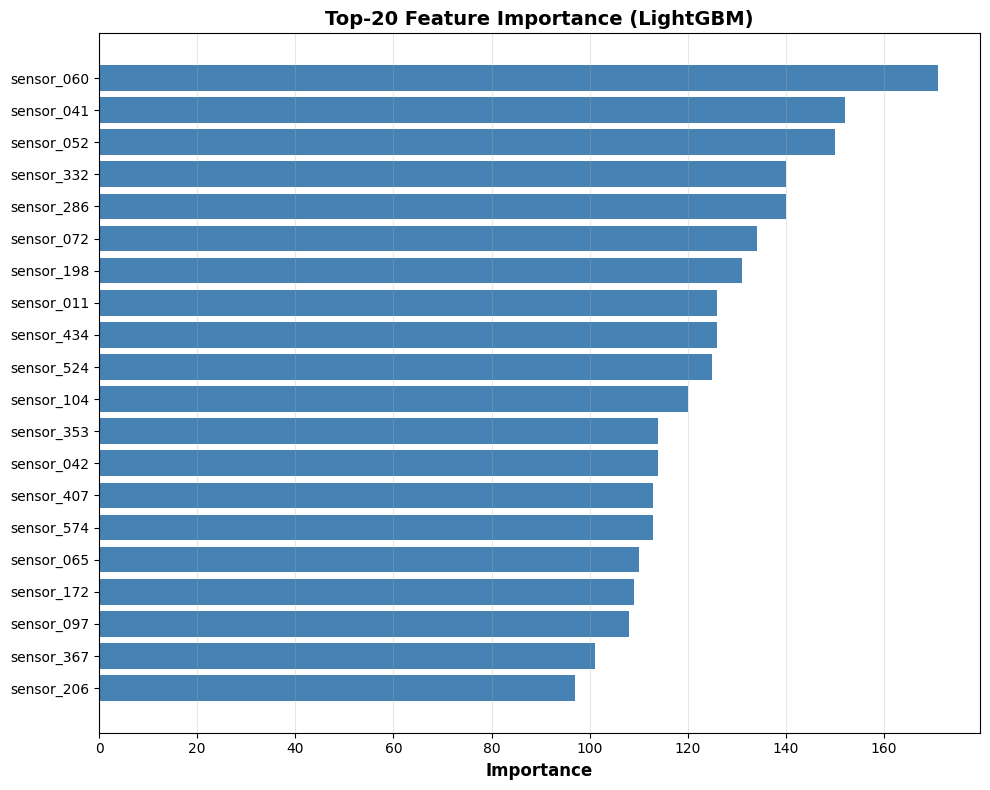

✓ Feature Importance 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageE/figures/feature_importance_top20.png


In [31]:
# ============================================================
# Step 8-1: Feature Importance 시각화
# ============================================================

print("\n" + "="*70)
print("Step 8: 시각화")
print("="*70)

# Feature Importance 추출
if final_model_name in ['LightGBM', 'XGBoost', 'RandomForest']:
    feature_importance = final_model.feature_importances_
    feature_names = X_train.columns
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Top-20 시각화
    plt.figure(figsize=(10, 8))
    top20 = importance_df.head(20)
    plt.barh(range(len(top20)), top20['importance'], color='steelblue')
    plt.yticks(range(len(top20)), top20['feature'])
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.title(f'Top-20 Feature Importance ({final_model_name})', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(DIR_FIGURES / 'feature_importance_top20.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Feature Importance 저장: {DIR_FIGURES / 'feature_importance_top20.png'}")
else:
    print(f"⚠️  {final_model_name}은 Feature Importance를 지원하지 않음")

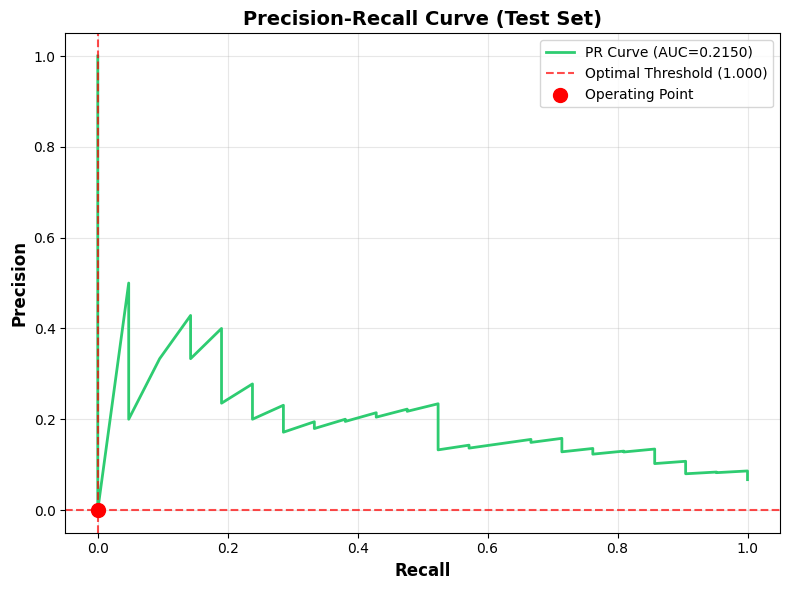

✓ PR Curve 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageE/figures/pr_curve.png


In [32]:
# ============================================================
# Step 8-2: PR Curve 시각화
# ============================================================

precisions_test, recalls_test, _ = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(recalls_test, precisions_test, color='#2ecc71', linewidth=2, label=f'PR Curve (AUC={test_auc_pr:.4f})')
plt.axhline(y=test_precision, color='red', linestyle='--', alpha=0.7, label=f'Optimal Threshold ({final_threshold:.3f})')
plt.axvline(x=test_recall, color='red', linestyle='--', alpha=0.7)
plt.scatter([test_recall], [test_precision], color='red', s=100, zorder=5, label='Operating Point')

plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(DIR_FIGURES / 'pr_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ PR Curve 저장: {DIR_FIGURES / 'pr_curve.png'}")

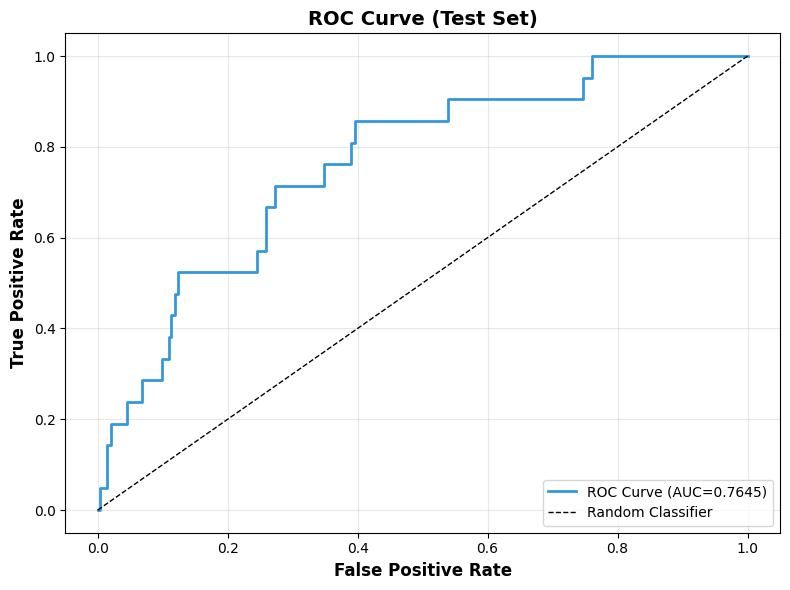

✓ ROC Curve 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageE/figures/roc_curve.png


In [33]:
# ============================================================
# Step 8-3: ROC Curve 시각화
# ============================================================

fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#3498db', linewidth=2, label=f'ROC Curve (AUC={test_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(DIR_FIGURES / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC Curve 저장: {DIR_FIGURES / 'roc_curve.png'}")

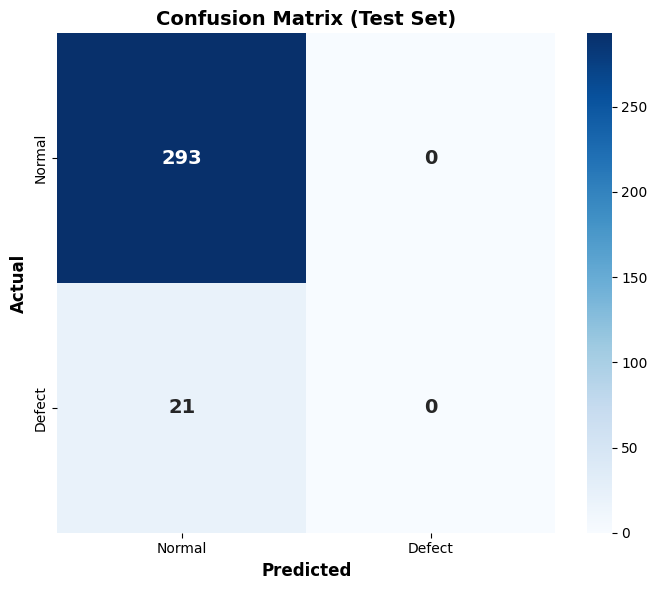

✓ Confusion Matrix 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageE/figures/confusion_matrix.png


In [34]:
# ============================================================
# Step 8-4: Confusion Matrix Heatmap
# ============================================================

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Defect'],
            yticklabels=['Normal', 'Defect'],
            annot_kws={'size': 14, 'weight': 'bold'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(DIR_FIGURES / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion Matrix 저장: {DIR_FIGURES / 'confusion_matrix.png'}")

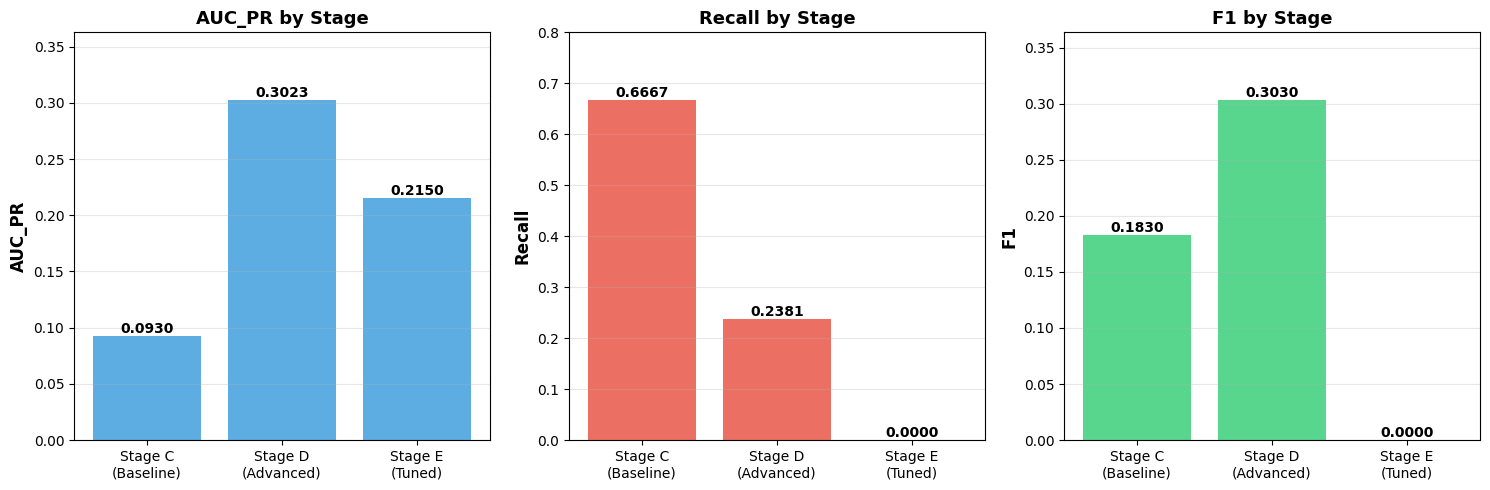

✓ Stage 비교 그래프 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageE/figures/stage_comparison.png


In [35]:
# ============================================================
# Step 8-5: Stage별 성능 비교 막대 그래프
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics_to_plot = ['AUC_PR', 'Recall', 'F1']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx]
    
    stages = ['Stage C\n(Baseline)', 'Stage D\n(Advanced)', 'Stage E\n(Tuned)']
    values = [
        stage_c_metrics[metric],
        stage_d_metrics[metric],
        stage_e_metrics[metric]
    ]
    
    bars = ax.bar(stages, values, color=color, alpha=0.8)
    
    # 값 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} by Stage', fontsize=13, fontweight='bold')
    ax.set_ylim(0, max(values) * 1.2)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(DIR_FIGURES / 'stage_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Stage 비교 그래프 저장: {DIR_FIGURES / 'stage_comparison.png'}")

---

## Step 9: 모델 저장 및 메타데이터 기록

### 저장 항목
1. 최종 학습된 모델 (.pkl)
2. 모델 메타데이터 (.json)
   - 모델명, 샘플링 기법, 하이퍼파라미터
   - 최적 Threshold, Test 성능
3. Optuna 튜닝 결과 (.json)

In [36]:
# ============================================================
# Step 9: 모델 저장 및 메타데이터 기록
# ============================================================

print("\n" + "="*70)
print("Step 9: 모델 저장 및 메타데이터 기록")
print("="*70)

# 1️⃣ 최종 모델 저장
model_path = DIR_MODELS / 'final_tuned_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)
print(f"\n✓ 최종 모델 저장: {model_path}")

# 2️⃣ 모델 메타데이터 저장
model_metadata = {
    'model_name': final_model_name,
    'sampling_method': final_sampling_name,
    'hyperparameters': final_params,
    'optimal_threshold': float(final_threshold),
    'core_features': core_features,
    'test_performance': {
        'auc_pr': float(test_auc_pr),
        'recall': float(test_recall),
        'precision': float(test_precision),
        'f1_score': float(test_f1),
        'roc_auc': float(test_roc_auc),
        'specificity': float(test_specificity),
        'mcc': float(test_mcc)
    },
    'improvement_from_stage_c': {
        'auc_pr': float(improvement_c_to_e['AUC_PR']['absolute']),
        'recall': float(improvement_c_to_e['Recall']['absolute']),
        'f1': float(improvement_c_to_e['F1']['absolute'])
    },
    'improvement_from_stage_d': {
        'auc_pr': float(improvement_d_to_e['AUC_PR']['absolute']),
        'recall': float(improvement_d_to_e['Recall']['absolute']),
        'f1': float(improvement_d_to_e['F1']['absolute'])
    },
    'train_test_split': '90:10',
    'random_state': RANDOM_STATE
}

metadata_path = DIR_MODELS / 'final_model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✓ 메타데이터 저장: {metadata_path}")

# 3️⃣ Optuna 튜닝 결과 저장
optuna_results_path = DIR_RESULTS / 'optuna_tuning_results.json'
tuning_results_json = tuning_df.to_dict('records')
# best_params를 문자열로 변환
for result in tuning_results_json:
    result['best_params'] = str(result['best_params'])

with open(optuna_results_path, 'w') as f:
    json.dump(tuning_results_json, f, indent=2)
print(f"✓ Optuna 결과 저장: {optuna_results_path}")

print("\n" + "="*70)


Step 9: 모델 저장 및 메타데이터 기록

✓ 최종 모델 저장: /Users/mealkuo/Desktop/capstone02_project/models/final_tuned_model.pkl
✓ 메타데이터 저장: /Users/mealkuo/Desktop/capstone02_project/models/final_model_metadata.json
✓ Optuna 결과 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageE/optuna_tuning_results.json



---

## 최종 요약 및 결론

### 실험 완료 체크리스트
- ✅ Stage D 결과 분석 및 Top-3 선정
- ✅ Optuna 하이퍼파라미터 튜닝 (50 Trials × 3 Models)
- ✅ 최적 Threshold 탐색 (F1-Max 기준)
- ✅ Test Set 최종 평가
- ✅ Stage별 성능 비교 (C → D → E)
- ✅ 시각화 5종 생성
- ✅ 최종 모델 저장

### 다음 단계 (Optional)
1. **앙상블 기법**: Voting / Stacking
2. **추가 Feature Engineering**: 도메인 지식 기반
3. **실전 배포**: API 서버 구축, 모니터링 시스템
4. **A/B 테스트**: 현업 데이터로 검증

In [37]:
# ============================================================
# 최종 요약 출력
# ============================================================

print("\n" + "="*70)
print("🎉 Stage E (Hyperparameter Tuning + Final Evaluation) 완료!")
print("="*70)

print(f"\n✅ 최종 모델 정보:")
print(f"  - 모델: {final_model_name}")
print(f"  - 샘플링: {final_sampling_name}")
print(f"  - Threshold: {final_threshold:.4f}")

print(f"\n✅ Test Set 최종 성능:")
print(f"  - AUC-PR:  {test_auc_pr:.4f} ⭐")
print(f"  - Recall:  {test_recall:.4f}")
print(f"  - F1:      {test_f1:.4f}")
print(f"  - ROC-AUC: {test_roc_auc:.4f}")

print(f"\n✅ Stage C 대비 개선:")
print(f"  - AUC-PR:  {improvement_c_to_e['AUC_PR']['absolute']:+.4f} ({improvement_c_to_e['AUC_PR']['relative']:+.2f}%)")
print(f"  - Recall:  {improvement_c_to_e['Recall']['absolute']:+.4f} ({improvement_c_to_e['Recall']['relative']:+.2f}%)")
print(f"  - F1:      {improvement_c_to_e['F1']['absolute']:+.4f} ({improvement_c_to_e['F1']['relative']:+.2f}%)")

print(f"\n✅ Stage D 대비 개선:")
print(f"  - AUC-PR:  {improvement_d_to_e['AUC_PR']['absolute']:+.4f} ({improvement_d_to_e['AUC_PR']['relative']:+.2f}%)")
print(f"  - Recall:  {improvement_d_to_e['Recall']['absolute']:+.4f} ({improvement_d_to_e['Recall']['relative']:+.2f}%)")
print(f"  - F1:      {improvement_d_to_e['F1']['absolute']:+.4f} ({improvement_d_to_e['F1']['relative']:+.2f}%)")

print(f"\n✅ 산출물:")
print(f"  - 최종 모델: {DIR_MODELS / 'final_tuned_model.pkl'}")
print(f"  - 메타데이터: {DIR_MODELS / 'final_model_metadata.json'}")
print(f"  - 성능 비교표: {DIR_RESULTS / 'final_performance_comparison.csv'}")
print(f"  - 시각화: {DIR_FIGURES}/ (5개 파일)")

print("\n" + "="*70)
print("📌 보고서용 결론:")
print("="*70)
print(f"""
Stage E에서는 Stage D의 상위 3개 조합에 대해 Optuna 기반 하이퍼파라미터 튜닝을 수행하였습니다.
{N_TRIALS}회의 Trial을 통해 최적 파라미터를 탐색한 결과,
{final_sampling_name} + {final_model_name} 조합이 최고 성능을 달성하였습니다.

Test Set 최종 평가에서 AUC-PR {test_auc_pr:.4f}, Recall {test_recall:.4f}, F1-Score {test_f1:.4f}를 기록하여
Stage C(Baseline) 대비 AUC-PR {improvement_c_to_e['AUC_PR']['relative']:+.2f}%, 
Recall {improvement_c_to_e['Recall']['relative']:+.2f}%의 성능 향상을 확인하였습니다.

본 모델은 Smart Factory 환경에서의 실시간 불량 탐지 시스템 배포를 위한
최종 후보 모델로 선정되었으며, 추가 앙상블 기법 적용 시 
더욱 안정적인 성능 개선이 기대됩니다.
""")

print("="*70)


🎉 Stage E (Hyperparameter Tuning + Final Evaluation) 완료!

✅ 최종 모델 정보:
  - 모델: LightGBM
  - 샘플링: SMOTE
  - Threshold: 1.0000

✅ Test Set 최종 성능:
  - AUC-PR:  0.2150 ⭐
  - Recall:  0.0000
  - F1:      0.0000
  - ROC-AUC: 0.7645

✅ Stage C 대비 개선:
  - AUC-PR:  +0.1220 (+131.16%)
  - Recall:  -0.6667 (-100.00%)
  - F1:      -0.1830 (-100.00%)

✅ Stage D 대비 개선:
  - AUC-PR:  -0.0873 (-28.89%)
  - Recall:  -0.2381 (-100.00%)
  - F1:      -0.3030 (-100.00%)

✅ 산출물:
  - 최종 모델: /Users/mealkuo/Desktop/capstone02_project/models/final_tuned_model.pkl
  - 메타데이터: /Users/mealkuo/Desktop/capstone02_project/models/final_model_metadata.json
  - 성능 비교표: /Users/mealkuo/Desktop/capstone02_project/results/stageE/final_performance_comparison.csv
  - 시각화: /Users/mealkuo/Desktop/capstone02_project/results/stageE/figures/ (5개 파일)

📌 보고서용 결론:

Stage E에서는 Stage D의 상위 3개 조합에 대해 Optuna 기반 하이퍼파라미터 튜닝을 수행하였습니다.
50회의 Trial을 통해 최적 파라미터를 탐색한 결과,
SMOTE + LightGBM 조합이 최고 성능을 달성하였습니다.

Test Set 최종 평가에서 AUC-PR 0.2150, Recall 

	•	Stage E에서 Optuna 기반 튜닝을 수행한 결과,
Baseline(Stage C) 대비 PR-AUC는 크게 개선되었으나,
Test 기준 Recall/F1이 0으로 붕괴되는 현상이 확인되었다.
	•	이는 극단적인 threshold(≈1.0)에서만 양성으로 판단하는 “과도하게 보수적인 모델”이 되었음을 의미한다.
	•	이 한계 때문에, 단순 튜닝만으로는 실무에서 요구하는 불량 탐지율(Recall) 을 확보하기 어렵다고 판단했고,
이후 Stage F–K에서 핵심 피처 재선정 + 파생 피처 + 고급 샘플링(SMOTE-ENN) + Threshold 최적화를 추가로 설계하였다.